## Grouping by season in order to plot along elevation.

In [49]:
import s3fs
import xarray as xr
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022')

['escience2022/Ada',
 'escience2022/Antoine',
 'escience2022/Dominic',
 'escience2022/ESA_SMOS_sss',
 'escience2022/Remy',
 'escience2022/Sara',
 'escience2022/Zhihong']

In [50]:
varl = ['N100','N200','N50', 'BC_AI'] 

In [51]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_full/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc'

In [52]:
def make_file_path_for_var(v,):
    return path_to_data+v+postfix

In [53]:
filelist = [make_file_path_for_var(v) for v in varl]

In [54]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

In [55]:
sulphate_varl = ['SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC','SO4_PR'] 

In [56]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

In [57]:
filelist = [make_file_path_for_var(v) for v in sulphate_varl]

In [58]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

In [59]:
ds['SO4_tot'] = 0
for var in sulphate_varl:
    ds['SO4_tot'] = ds['SO4_tot'] + ds[var]

ds['SO4_tot'].attrs['units'] = ds[var].attrs['units']

In [60]:
T_standard =  273.15 #K
p_standard = 1e5 #Pa
R = 287.058

rho = p_standard/(R*T_standard)
rho

1.2753492774515685

In [61]:
var = 'SO4_tot'
if ds[var].attrs['units'] =='kg/kg':
    ds[var] = ds[var]*rho
    ds[var].attrs['units'] = 'kg/m3'
    ## Change to ug/m3
    ds[var] = ds[var]*1e9
    ds[var].attrs['units'] = 'ug/m3'
                

In [62]:
filelist = [make_file_path_for_var(v) for v in varl]

In [63]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds_aero = xr.open_mfdataset(list_of_s3_obj)

In [64]:
import matplotlib.pyplot as plt

In [65]:
ds =xr.merge([ds,ds_aero])

In [66]:
ds_season = ds.groupby('time.season').mean()
ds_season['SO4_tot'].attrs['units'] = 'ug/m3'
ds_season['SO4_tot'].attrs['long_name'] = 'Total Sulphate Concentration'
ds_season['N100'].attrs['units'] = 'm$^-3$'
ds_season['N100'].attrs['long_name'] = 'N$_100$'
ds_season

<xarray.Dataset>
Dimensions:   (location: 5, season: 4, lev: 32)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    SO4_A1    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_A2    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_AC    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_NA    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_PR    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_tot   (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    BC_AI     (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    N100      (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    N200      (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    N50       (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>

In [68]:
ds_season = ds_season.load()

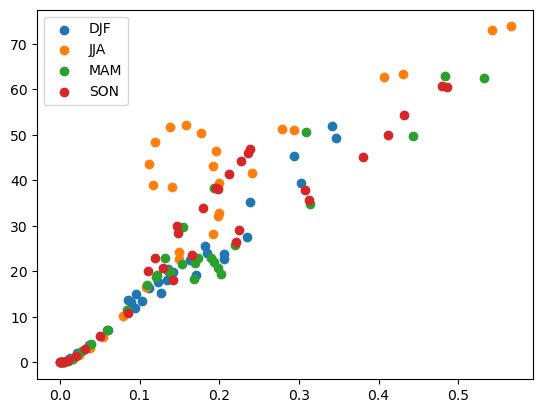

In [69]:
for seas in ds_season.season:
    plt.scatter(x = ds_season['SO4_tot'].sel(season=seas,location = 'Zeppelin'), 
                y = ds_season['N100'].sel(season=seas,location = 'Zeppelin'),
                label=seas.values)
                
plt.legend()

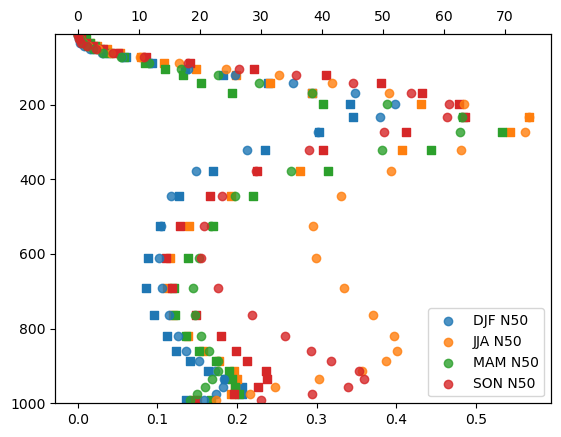

In [70]:
ig, ax1 = plt.subplots()

for seas in ds_season.season:
    ax1.scatter(x = ds_season['SO4_tot'].sel(season=seas,location = 'Zeppelin'), 
                y = ds_season['lev'],
                marker = 's',
                label=f'{seas.values} SO4')
ax1.set_ylim(ax1.get_ylim()[::-1])

ax2 = ax1.twiny() 
for seas in ds_season.season:
    ax2.scatter(x = ds_season['N100'].sel(season=seas,location = 'Zeppelin'), 
                y = ds_season['lev'],
                label=f'{seas.values} N50', alpha = 0.8)

ax1.set_ylim([1000,10])
plt.legend()

In [71]:
percentage_SO4 = (ds_season['SO4_tot']/(ds_season['SO4_tot'].max()))
percentage_N100 = (ds_season['N100']/(ds_season['N100'].max()))
percentage_SO4 = percentage_SO4.load()
percentage_N100 = percentage_N100.load()

In [72]:
factor = percentage_SO4 / percentage_N100
N100_div_SO4 = percentage_N100/percentage_SO4

(1042.0017265947536, -45.80216577742249)

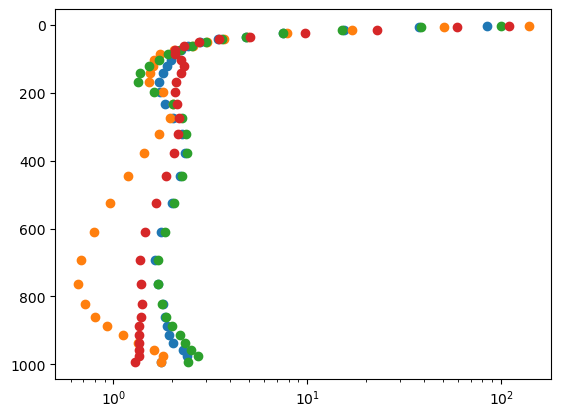

In [73]:
fig, ax = plt.subplots()
for seas in factor.season:
    ax.scatter(x= factor.sel(season=seas,location = 'Zeppelin'),
               y= factor['lev'],
              label=seas.values)
ax.set_xscale('log')
ax.set_ylim(ax.get_ylim()[::-1])

(1042.0017265947536, -45.80216577742249)

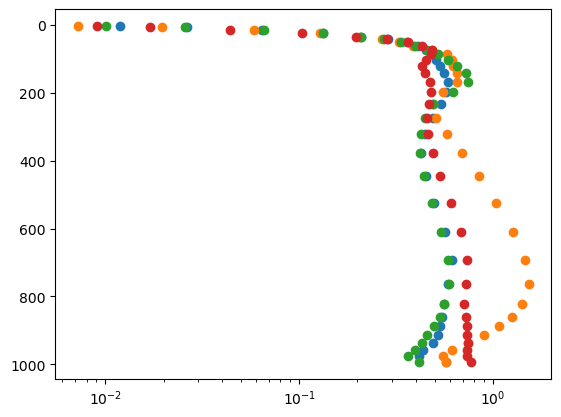

In [74]:
fig, ax = plt.subplots()
for seas in N100_div_SO4.season:
    ax.scatter(x= N100_div_SO4.sel(season=seas,location = 'Zeppelin'),
               y= N100_div_SO4['lev'],
              label=seas.values)
ax.set_xscale('log')
ax.set_ylim(ax.get_ylim()[::-1])

## Daily resample and the N50 and N100 ploted against SO4 total

In [75]:
ds_daily = ds.resample(time='d').mean('time')
ds_daily['season']= ds_daily['time.season']

ds_daily

<xarray.Dataset>
Dimensions:   (location: 5, time: 1098, lev: 32)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-01-02
Data variables:
    SO4_A1    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_A2    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_AC    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_NA    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_PR    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_tot   (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    BC_AI     (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N200      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    season    (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

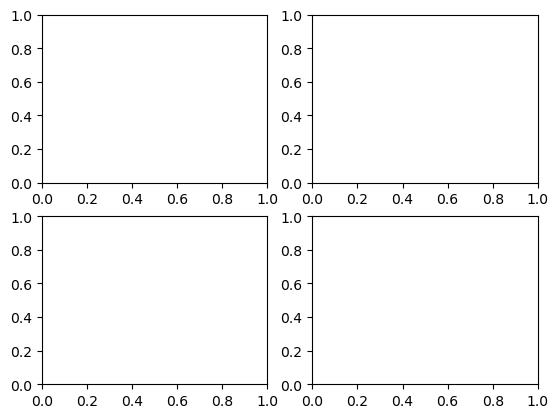

In [76]:
fig, axs = plt.subplots(2,2)



In [77]:
ds_daily

<xarray.Dataset>
Dimensions:   (location: 5, time: 1098, lev: 32)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-01-02
Data variables:
    SO4_A1    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_A2    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_AC    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_NA    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_PR    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_tot   (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    BC_AI     (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N200      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    season    (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

In [78]:
_ds = ds_daily.sel(location='Zeppelin').isel(lev=-1)


_ds =_ds.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [79]:
_ds['season'] = _ds['time.season']

In [80]:
import numpy as np

DJF
 
234.5 x + 16.4
MAM
 
344.3 x + 25.05
JJA
 
325.9 x + 31.91
SON
 
450.5 x + 1.657


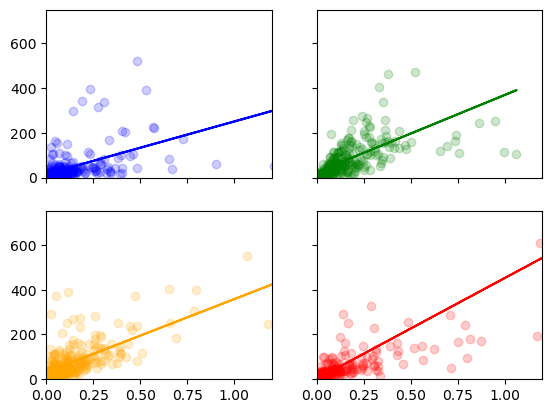

In [103]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N50'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    p = np.poly1d(z)
    ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    print(p)
    ax.set_ylim ([0,750])
    ax.set_xlim ([0,1.2])
    #ax.set_yscale ('log')
    #ax.set_xscale ('log')

DJF
 
234.5 x + 16.4
MAM
 
344.3 x + 25.05
JJA
 
325.9 x + 31.91
SON
 
450.5 x + 1.657


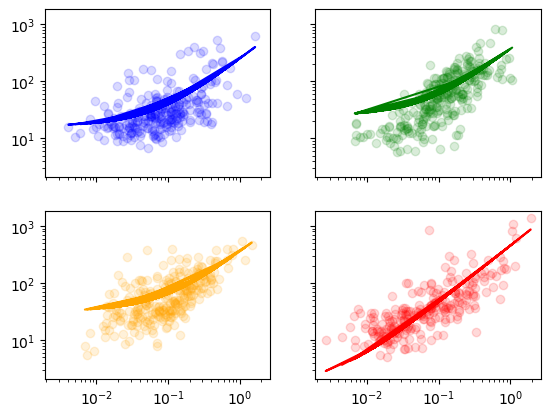

In [104]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N50'],c= col, alpha = 0.15)
    z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    p = np.poly1d(z)
    ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    print(p)
    #ax.set_ylim ([0,750])
    #ax.set_xlim ([0,1.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

DJF
MAM
JJA
SON


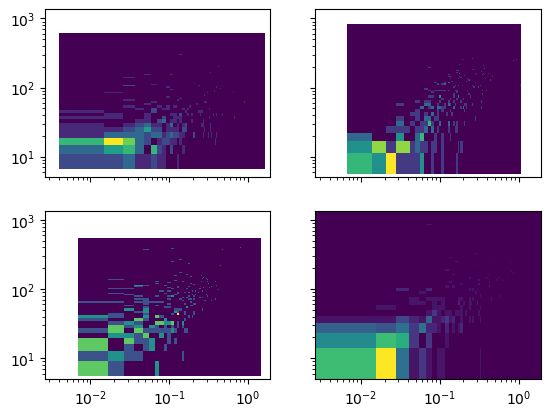

In [117]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.hist2d(x=_dss['SO4_tot'], y=_dss['N50'],bins = 150)
    #z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    #p = np.poly1d(z)
    #ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

DJF
 
124.6 x + 3.773
MAM
 
82.24 x + 4.635
JJA
 
113.6 x + 5.653
SON
 
173.3 x + 2.375


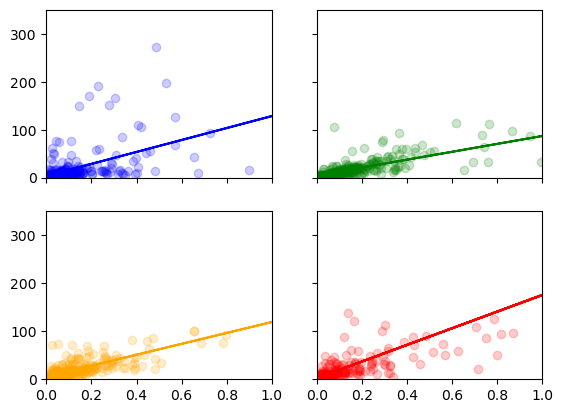

In [120]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    print(p)
    ax.set_ylim ([0,350])
    ax.set_xlim ([0,1])
    #ax.set_yscale ('log')
    #ax.set_xscale ('log')

DJF
 
124.6 x + 3.773
MAM
 
82.24 x + 4.635
JJA
 
113.6 x + 5.653
SON
 
173.3 x + 2.375


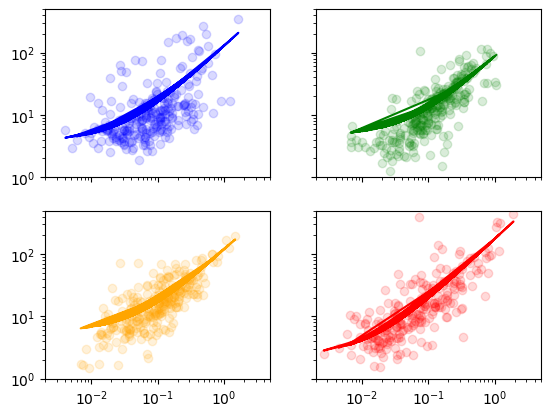

In [129]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'],c= col, alpha = 0.15)
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    print(p)
    ax.set_ylim ([1,500])
    ax.set_xlim ([0.002,5])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

DJF
MAM
JJA
SON


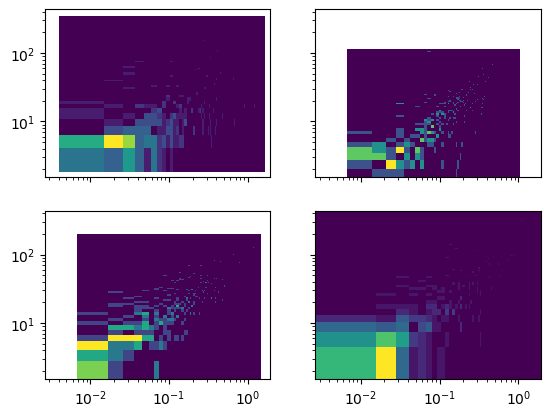

In [128]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.hist2d(x=_dss['SO4_tot'], y=_dss['N100'],bins = 150)
    #z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    #p = np.poly1d(z)
    #ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')